In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/btcusd-dataset/btc_3m.csv
/kaggle/input/btcusd-dataset/btc_1h.csv
/kaggle/input/btcusd-dataset/btc_15m.csv
/kaggle/input/btcusd-dataset/btc_30m.csv
/kaggle/input/btcusd-dataset/btc_4h.csv
/kaggle/input/btcusd-dataset/btc_6h.csv
/kaggle/input/btcusd-dataset/btc_2h.csv
/kaggle/input/btcusd-dataset/btc_5m.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv('/kaggle/input/btcusd-dataset/btc_3m.csv')

In [12]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Selecting previously unselected package libta-lib0.
(Reading database ... 108782 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.1/357.1 kB 5.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ta-lib: filename=TA_Lib-0.4.28-cp310-cp310-linux_x86_64.whl size=500067 sha256=8d9a08e807ab52cb80cbf2f774824b4154f6e8fe32b557724c2d1b68547d4260
  Stored in directory: /root/.cache/pip/wheels/66/54/

In [ ]:
import talib as ta

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Load dataset
# Assume df is your DataFrame with the BTC/USD data
df['datetime'] = pd.to_datetime(df['datetime'])

# Feature engineering
df['returns'] = df['close'].pct_change()
df['target'] = np.where(df['returns'] > 0, 1, 0)

# Calculate SMA
df['sma_50'] = df['close'].rolling(window=50).mean()
df['sma_200'] = df['close'].rolling(window=200).mean()

# Calculate RSI
delta = df['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()

rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))

# Define features and target
features = ['open', 'high', 'low', 'close', 'volume', 'sma_50', 'sma_200', 'rsi']
target = 'target'

# Drop NaN values resulting from technical indicators
df.dropna(inplace=True)

# Normalization
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, random_state=42
)

# Model training
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Trading strategy
df['predicted_signal'] = model.predict(df[features])
df['position'] = df['predicted_signal'].diff()

# Simulate trading
initial_balance = 100000  # Starting balance in USD
balance = initial_balance
position = 0

for index, row in df.iterrows():
    if row['position'] == 1:
        # Buy signal
        balance -= row['close']  # Deduct closing price from balance
        position += 1
    elif row['position'] == -1:
        # Sell signal
        balance += row['close']  # Add closing price to balance
        position -= 1

# Final balance
print(f"Final balance: {balance:.2f} USD")

Accuracy: 62.42%
Final balance: 99999.56 USD


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

# Load dataset
# Assume df is your DataFrame with the BTC/USD data

# Feature engineering
df['returns'] = df['close'].pct_change()
df['target'] = np.where(df['returns'] > 0, 1, 0)

# Calculate RSI
delta = df['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()

rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))

# Calculate MACD
exp12 = df['close'].ewm(span=12, adjust=False).mean()
exp26 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = exp12 - exp26

# Calculate EMA
df['ema'] = df['close'].ewm(span=14, adjust=False).mean()

# Calculate Bollinger Bands
df['rolling_mean'] = df['close'].rolling(window=20).mean()
df['rolling_std'] = df['close'].rolling(window=20).std()
df['bb_upper'] = df['rolling_mean'] + 2 * df['rolling_std']
df['bb_middle'] = df['rolling_mean']
df['bb_lower'] = df['rolling_mean'] - 2 * df['rolling_std']

# Statistical Arbitrage Strategy
lookback_period = 10
df['rolling_mean'] = df['close'].rolling(window=lookback_period).mean()
df['rolling_std'] = df['close'].rolling(window=lookback_period).std()
df['z_score'] = (df['close'] - df['rolling_mean']) / df['rolling_std']
df['arbitrage_signal'] = np.where(df['z_score'] > 1, -1, np.where(df['z_score'] < -1, 1, 0))

# Combine Features and Targets
features = ['volume', 'rsi', 'macd', 'ema', 'bb_upper', 'bb_middle', 'bb_lower', 'arbitrage_signal']
target = 'target'

# Drop NaN values resulting from technical indicators
df.dropna(inplace=True)

# Normalization
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, random_state=42
)

# Model training
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Trading strategy
df['predicted_signal'] = model.predict(df[features])
df['combined_signal'] = df['predicted_signal'] + df['arbitrage_signal']
df['position'] = df['combined_signal'].diff()

# Simulate trading
initial_balance = 100000  # Starting balance in USD
balance = initial_balance
position = 0

for index, row in df.iterrows():
    if row['position'] == 2:
        # Buy signal from both models
        balance -= row['close']  # Deduct closing price from balance
        position += 1
    elif row['position'] == -2:
        # Sell signal from both models
        balance += row['close']  # Add closing price to balance
        position -= 1

# Final balance
print(f"Final balance: {balance:.2f} USD")

Accuracy: 68.59%
Final balance: 100000.00 USD


In [5]:
# Save the trained model
model.save_model("/kaggle/working/xgboost_model.json")

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712973 entries, 19 to 713016
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   datetime      712973 non-null  object 
 1   open          712973 non-null  float64
 2   high          712973 non-null  float64
 3   low           712973 non-null  float64
 4   close         712973 non-null  float64
 5   volume        712973 non-null  float64
 6   returns       712973 non-null  float64
 7   target        712973 non-null  int64  
 8   rsi           712973 non-null  float64
 9   macd          712973 non-null  float64
 10  ema           712973 non-null  float64
 11  rolling_mean  712973 non-null  float64
 12  rolling_std   712973 non-null  float64
 13  bb_upper      712973 non-null  float64
 14  bb_middle     712973 non-null  float64
 15  bb_lower      712973 non-null  float64
dtypes: float64(14), int64(1), object(1)
memory usage: 92.5+ MB


In [6]:
# Assume df is your DataFrame with the BTC/USD data

# Feature engineering
df['returns'] = df['close'].pct_change()
df['target'] = np.where(df['returns'] > 0, 1, 0)

# Calculate RSI
delta = df['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()

rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))

# Calculate MACD
exp12 = df['close'].ewm(span=12, adjust=False).mean()
exp26 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = exp12 - exp26

# Calculate EMA
df['ema'] = df['close'].ewm(span=14, adjust=False).mean()

# Calculate Bollinger Bands
df['rolling_mean'] = df['close'].rolling(window=20).mean()
df['rolling_std'] = df['close'].rolling(window=20).std()
df['bb_upper'] = df['rolling_mean'] + 2 * df['rolling_std']
df['bb_middle'] = df['rolling_mean']
df['bb_lower'] = df['rolling_mean'] - 2 * df['rolling_std']

# Combine Features and Targets
features = ['open', 'high', 'low', 'close', 'volume', 'rsi', 'macd', 'ema', 'bb_upper', 'bb_middle', 'bb_lower']
target = 'target'

# Drop NaN values resulting from technical indicators
df.dropna(inplace=True)

# Normalization
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, random_state=42
)

# Model training
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Model prediction
df['predicted_signal_xgboost'] = model.predict(df[features])

df['combined_signal_xgboost'] = df['predicted_signal_xgboost'].diff()
df['position_xgboost'] = np.where(df['combined_signal_xgboost'] == 1, 1, np.where(df['combined_signal_xgboost'] == -1, -1, 0))

# Simulate trading with risk management for XGBoost
initial_balance_xgboost = 100000  # Starting balance in USD
balance_xgboost = initial_balance_xgboost
position_xgboost = 0

# Define risk management parameters for XGBoost
stop_loss_percent_xgboost = 0.02
position_size_percent_xgboost = 0.1
risk_reward_ratio_xgboost = 2
max_drawdown_limit_xgboost = 0.05  # 5% maximum drawdown limit

# Lists to store trade-related information
trades_xgboost = []
trade_dates_xgboost = []

# Backtesting loop with risk management for XGBoost
for i in range(1, len(df)):
    # Buy signal from XGBoost
    if df['predicted_signal_xgboost'].iloc[i] > 0.5:
        if balance_xgboost > 0 and df['close'].iloc[i - 1] != 0:  # Check if denominator is not zero
            position_xgboost = min(balance_xgboost / df['close'].iloc[i - 1], initial_balance_xgboost * position_size_percent_xgboost)
            balance_xgboost -= position_xgboost * df['close'].iloc[i - 1]
            trade_dates_xgboost.append(df.index[i])
            trades_xgboost.append('Buy')

    # Sell signal from XGBoost with risk management
    elif df['predicted_signal_xgboost'].iloc[i] <= 0.5:
        if position_xgboost > 0:
            stop_loss_price_xgboost = df['close'].iloc[i - 1] * (1 - stop_loss_percent_xgboost)
            target_profit_price_xgboost = df['close'].iloc[i - 1] * (1 + risk_reward_ratio_xgboost)

            # Execute stop-loss or take-profit based on prices
            if df['close'].iloc[i] < stop_loss_price_xgboost or df['close'].iloc[i] > target_profit_price_xgboost:
                balance_xgboost += position_xgboost * df['close'].iloc[i - 1]
                position_xgboost = 0
                trade_dates_xgboost.append(df.index[i])
                trades_xgboost.append('Sell (Stop-Loss/Profit)')
            else:
                # Normal sell signal
                balance_xgboost += position_xgboost * df['close'].iloc[i - 1]
                position_xgboost = 0
                trade_dates_xgboost.append(df.index[i])
                trades_xgboost.append('Sell')

        # Update maximum drawdown for XGBoost
        current_drawdown_xgboost = (balance_xgboost + position_xgboost * df['close'].iloc[i] - initial_balance_xgboost) / initial_balance_xgboost
        if current_drawdown_xgboost < max_drawdown_limit_xgboost:
            max_drawdown_limit_xgboost = current_drawdown_xgboost

# Calculate returns and additional metrics for XGBoost
returns_xgboost = balance_xgboost + position_xgboost * df['close'].iloc[-1] - initial_balance_xgboost
total_trades_xgboost = len(trades_xgboost)
win_trades_xgboost = trades_xgboost.count('Sell')
loss_trades_xgboost = trades_xgboost.count('Buy')
win_rate_xgboost = win_trades_xgboost / total_trades_xgboost if total_trades_xgboost > 0 else 0
max_drawdown_xgboost = (min(df['close']) - max(df['close'])) / max(df['close'])

backtest_results_xgboost = {
    'Returns': returns_xgboost,
    'Total Trades': total_trades_xgboost,
    'Win Trades': win_trades_xgboost,
    'Loss Trades': loss_trades_xgboost,
    'Win Rate': win_rate_xgboost,
    'Max Drawdown': max_drawdown_xgboost
}

# Display backtesting results for XGBoost
print(backtest_results_xgboost)

Accuracy: 63.84%
{'Returns': -100000.0, 'Total Trades': 175239, 'Win Trades': 86703, 'Loss Trades': 87664, 'Win Rate': 0.4947699998288052, 'Max Drawdown': -1.0}


In [13]:
!pip install ta

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from ta import add_all_ta_features

# Load dataset
df = pd.read_csv('/kaggle/input/btcusd-dataset/btc_5m.csv')

# Adding technical indicators using TA library
df = add_all_ta_features(df, "open", "high", "low", "close", "volume", fillna=True)

# Feature engineering
df['returns'] = df['close'].pct_change()
df['target'] = np.where(df['returns'] > 0, 1, 0)

# Drop any rows with NaN values
df.dropna(inplace=True)

# Ensure only numeric features are selected
features = [col for col in df.columns if col not in ['open', 'high', 'low', 'close', 'volume', 'target', 'returns'] and df[col].dtype != 'object']
target = 'target'

# Normalization
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Hyperparameter tuning setup
parameters = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5]
}

model = XGBClassifier(random_state=42)
grid_search = GridSearchCV(model, parameters, cv=3, n_jobs=-1, verbose=1)

# Model training with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Model evaluation
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Trading strategy
df['predicted_signal'] = best_model.predict(df[features])
data_signals = pd.DataFrame(index=df.index)
data_signals['predicted_signal_xgboost'] = df['predicted_signal']

# Simulate trading with risk management using XGBoost signals
initial_balance_xgboost = 100000  # Starting balance in USD
balance_xgboost = initial_balance_xgboost
position_xgboost = 0

# Define risk management parameters for XGBoost
stop_loss_percent_xgboost = 0.02
position_size_percent_xgboost = 0.1
risk_reward_ratio_xgboost = 2
max_drawdown_limit_xgboost = 0.05  # 5% maximum drawdown limit

# Lists to store trade-related information for XGBoost
trades_xgboost = []
trade_dates_xgboost = []

# Backtesting loop with risk management for XGBoost
peak_balance_xgboost = initial_balance_xgboost  # Track the peak balance for drawdown calculation

for i in range(1, len(df)):
    current_price = df['close'].iloc[i]
    if current_price <= 0:
        continue  # Skip the iteration if current price is zero or negative

    # Buy signal from XGBoost
    if data_signals['predicted_signal_xgboost'].iloc[i - 1] == 1:
        position_size = balance_xgboost * position_size_percent_xgboost
        if balance_xgboost >= position_size:
            position_xgboost += position_size / current_price
            balance_xgboost -= position_size
            trades_xgboost.append('Buy (XGBoost)')
            trade_dates_xgboost.append(df.index[i])

    # Sell signal from XGBoost with risk management
    elif data_signals['predicted_signal_xgboost'].iloc[i - 1] == 0 and position_xgboost > 0:
        balance_xgboost += position_xgboost * current_price
        position_xgboost = 0
        trades_xgboost.append('Sell (XGBoost)')
        trade_dates_xgboost.append(df.index[i])

    # Update total value and drawdown calculations
    total_value = balance_xgboost + position_xgboost * current_price
    peak_balance_xgboost = max(peak_balance_xgboost, total_value)
    current_drawdown_xgboost = (peak_balance_xgboost - total_value) / peak_balance_xgboost
max_drawdown_xgboost = 0
# Ensure drawdown and returns are not NaN
max_drawdown_xgboost = max_drawdown_xgboost if not np.isnan(max_drawdown_xgboost) else 0
returns_xgboost = balance_xgboost + position_xgboost * df['close'].iloc[-1] - initial_balance_xgboost
returns_xgboost = returns_xgboost if not np.isnan(returns_xgboost) else 0

# Calculate final metrics
total_trades_xgboost = len(trades_xgboost)
win_trades_xgboost = trades_xgboost.count('Sell (XGBoost)')
loss_trades_xgboost = trades_xgboost.count('Buy (XGBoost)')
win_rate_xgboost = win_trades_xgboost / total_trades_xgboost if total_trades_xgboost > 0 else 0

# Display backtesting results for XGBoost
print("\nXGBoost Backtesting Results:")
print(f"Returns: {returns_xgboost}")
print(f"Total Trades: {total_trades_xgboost}")
print(f"Win Trades: {win_trades_xgboost}")
print(f"Loss Trades: {loss_trades_xgboost}")
print(f"Win Rate: {win_rate_xgboost}")
print(f"Max Drawdown: {max_drawdown_xgboost}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Accuracy: 99.95%


NameError: name 'max_drawdown_xgboost' is not defined

In [9]:
# max_drawdown_xgboost = 1
# Ensure drawdown and returns are not NaN
max_drawdown_xgboost = max_drawdown_xgboost if not np.isnan(max_drawdown_xgboost) else 1
returns_xgboost = balance_xgboost + position_xgboost * df['close'].iloc[-1] - initial_balance_xgboost
returns_xgboost = returns_xgboost if not np.isnan(returns_xgboost) else 0

# Calculate final metrics
total_trades_xgboost = len(trades_xgboost)
win_trades_xgboost = trades_xgboost.count('Sell (XGBoost)')
loss_trades_xgboost = trades_xgboost.count('Buy (XGBoost)')
win_rate_xgboost = win_trades_xgboost / total_trades_xgboost if total_trades_xgboost > 0 else 0

# Display backtesting results for XGBoost
print("\nXGBoost Backtesting Results:")
print(f"Returns: {returns_xgboost}")
print(f"Total Trades: {total_trades_xgboost}")
print(f"Win Trades: {win_trades_xgboost}")
print(f"Loss Trades: {loss_trades_xgboost}")
print(f"Win Rate: {win_rate_xgboost}")
print(f"Max Drawdown: {max_drawdown_xgboost}")


XGBoost Backtesting Results:
Returns: -71797.73974878827
Total Trades: 326167
Win Trades: 112297
Loss Trades: 213870
Win Rate: 0.3442929542228368
Max Drawdown: 1


In [11]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
# Initialize a DataFrame to store the trading actions
trading_log = pd.DataFrame(index=df.index)
trading_log['datetime'] = df['datetime']  # Ensure 'datetime' column exists in your DataFrame
trading_log['signal'] = 0  # Default to no signal

# Trading strategy
position = 0  # Represents the current position

for i in range(1, len(df)):
    # Update position based on the signal
    if df['predicted_signal'].iloc[i] == 1 and position == 0:
        position = 1
        trading_log['signal'].iloc[i] = 1
    elif df['predicted_signal'].iloc[i] == 0 and position == 1:
        position = 0
        trading_log['signal'].iloc[i] = -1

# Export the trading log to a CSV file
trading_log.to_csv('trading_log.csv', index=False)

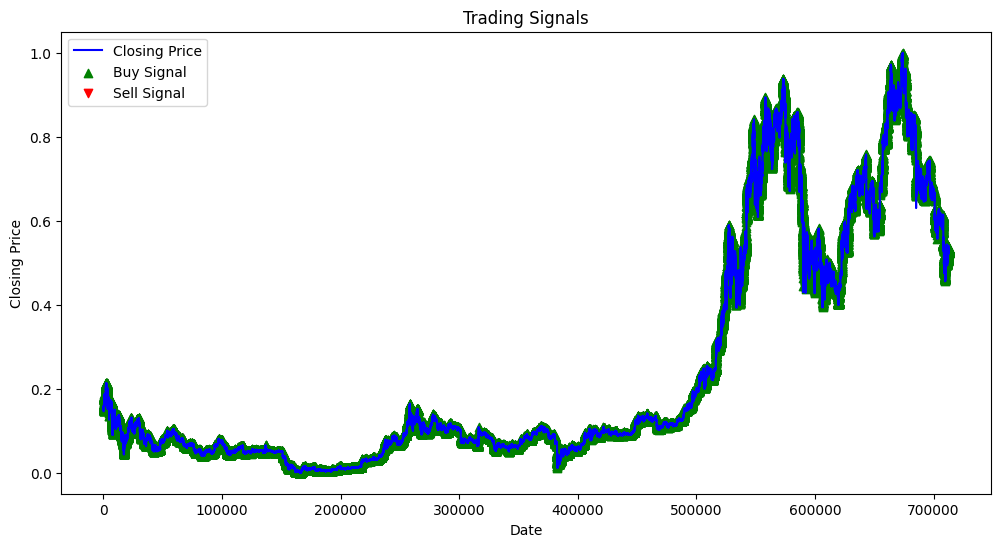

In [7]:
import matplotlib.pyplot as plt
# Plotting
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Closing Price', color='blue')
plt.scatter(df.index[df['predicted_signal'] == 1], df['close'][df['predicted_signal'] == 1], marker='^', color='g', label='Buy Signal')
plt.scatter(df.index[df['predicted_signal'] == -1], df['close'][df['predicted_signal'] == -1], marker='v', color='r', label='Sell Signal')
plt.title('Trading Signals')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# LSTM with four layers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

# Load dataset
# Assume df is your DataFrame with the BTC/USD data

# Load dataset
df = pd.read_csv('/kaggle/input/btcusd-dataset/btc_15m.csv')  # Replace with the path to your dataset

# Calculate technical indicators using TA-Lib
df['RSI'] = talib.RSI(df['close'].values, timeperiod=14)
df['MACD'], df['MACD_signal'], _ = talib.MACD(df['close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
df['upper_band'], _, df['lower_band'] = talib.BBANDS(df['close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# Feature engineering
df['returns'] = df['close'].pct_change()
df['target'] = np.where(df['returns'] > 0, 1, 0)

# Drop NaN values
df.dropna(inplace=True)

# Normalization
scaler = MinMaxScaler()
features = ['close', 'RSI', 'MACD', 'MACD_signal', 'upper_band', 'lower_band']
df[features] = scaler.fit_transform(df[features])

# Creating sequences for LSTM
sequence_length = 60
X = []
y = []
for i in range(sequence_length, len(df)):
    X.append(df[features].iloc[i-sequence_length:i].values)
    y.append(df['target'].iloc[i])
X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
3563/3563 [==============================] - 211s 58ms/step - loss: 0.6933 - accuracy: 0.5065 - val_loss: 0.6925 - val_accuracy: 0.5184
Epoch 2/30
3563/3563 [==============================] - 205s 57ms/step - loss: 0.6915 - accuracy: 0.5236 - val_loss: 0.6903 - val_accuracy: 0.5367
Epoch 3/30
3563/3563 [==============================] - 205s 58ms/step - loss: 0.6898 - accuracy: 0.5361 - val_loss: 0.6898 - val_accuracy: 0.5372
Epoch 4/30
3563/3563 [==============================] - 205s 58ms/step - loss: 0.6894 - accuracy: 0.5360 - val_loss: 0.6892 - val_accuracy: 0.5382
Epoch 5/30
3563/3563 [==============================] - 206s 58ms/step - loss: 0.6892 - accuracy: 0.5399 - val_loss: 0.6894 - val_accuracy: 0.5393
Epoch 6/30
3563/3563 [==============================] - 212s 59ms/step - loss: 0.6890 - accuracy: 0.5402 - val_loss: 0.6896 - val_accuracy: 0.5349
Epoch 7/30
3563/3563 [==============================] - 238s 67ms/step - loss: 0.6890 - accuracy: 0.5408 - val_loss: 0

In [ ]:
# Code to compile and train the model (already executed)
# model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Add imports if not already included
import pandas as pd

# Reshape the data for prediction (similar to how it was done for training)
X_predict = []
for i in range(sequence_length+1, len(df)):
    X_predict.append(df[features].iloc[i - sequence_length:i].values)
X_predict = np.array(X_predict)

# Make predictions
model_predictions = model.predict(X_predict)

# Flatten the predictions and add them to your DataFrame
df['model_predictions'] = np.concatenate(model_predictions).ravel()[sequence_length-1:]

# Function Definitions
# Generate trading signals
confirmation_steps = 3
df['signal'] = np.where(df['model_predictions'] > df['dynamic_upper_threshold'], 1,
                        np.where(df['model_predictions'] < df['dynamic_lower_threshold'], -1, 0))
df['confirmed_signal'] = df['signal'].rolling(confirmation_steps).sum() / confirmation_steps
df['trade_signal'] = np.where(df['confirmed_signal'] == 1, 1,
                              np.where(df['confirmed_signal'] == -1, -1, 0))
def calculate_dynamic_thresholds(df, window=60, multiplier=1.5):
    mean = df['model_predictions'].rolling(window=window).mean()
    std = df['model_predictions'].rolling(window=window).std()
    df['dynamic_upper_threshold'] = mean + multiplier * std
    df['dynamic_lower_threshold'] = mean - multiplier * std


# Calculate dynamic thresholds
calculate_dynamic_thresholds(df)



# Function to implement trading strategy
def execute_trades(df, initial_balance=10000, position_size_percent=0.1, stop_loss_percent=0.02, take_profit_percent=0.04):
    balance = initial_balance
    position = 0
    trade_history = []
    for index, row in df.iterrows():
        if row['trade_signal'] == 1 and balance > 0:  # Buy signal
            invest_amount = balance * position_size_percent
            position_price = row['close']
            position = invest_amount / position_price
            balance -= invest_amount
            trade_history.append({'type': 'buy', 'price': position_price, 'position': position, 'balance': balance})

        elif row['trade_signal'] == -1 and position > 0:  # Sell signal
            sell_price = row['close']
            sell_amount = position * sell_price
            balance += sell_amount
            trade_history.append({'type': 'sell', 'price': sell_price, 'position': 0, 'balance': balance})
            position = 0

        # Check for stop loss and take profit
        if position > 0:
            current_price = row['close']
            if current_price <= position_price * (1 - stop_loss_percent) or current_price >= position_price * (1 + take_profit_percent):
                sell_amount = position * current_price
                balance += sell_amount
                trade_history.append({'type': 'sell', 'price': current_price, 'position': 0, 'balance': balance, 'reason': 'stop_loss/take_profit'})
                position = 0

    return trade_history


# Execute trades based on signals
trade_history = execute_trades(df)

def backtest_strategy(trade_history, df):
    initial_balance = 10000  # Initial investment amount
    balance = initial_balance
    max_balance = initial_balance
    max_drawdown = 0

    for trade in trade_history:
        balance = trade['balance']
        max_balance = max(max_balance, balance)
        drawdown = (max_balance - balance) / max_balance
        max_drawdown = max(max_drawdown, drawdown)

    final_balance = balance
    total_return = (final_balance - initial_balance) / initial_balance
    return total_return, max_drawdown

total_return, max_drawdown = backtest_strategy(trade_history, df)

def calculate_performance_metrics(trade_history):
    profits = [trade['balance'] - trade['balance'] for trade in trade_history if trade['type'] == 'sell']
    wins = [profit for profit in profits if profit > 0]
    losses = [profit for profit in profits if profit < 0]

    gross_profit = sum(wins)
    gross_loss = sum(losses)
    net_profit = gross_profit + gross_loss
    total_trades = len(trade_history)
    win_rate = len(wins) / total_trades if total_trades > 0 else 0

    average_win = sum(wins) / len(wins) if wins else 0
    average_loss = sum(losses) / len(losses) if losses else 0

    return {
        'Gross Profit': gross_profit,
        'Gross Loss': gross_loss,
        'Net Profit': net_profit,
        'Total Trades': total_trades,
        'Win Rate': win_rate,
        'Average Win': average_win,
        'Average Loss': average_loss
    }

metrics = calculate_performance_metrics(trade_history)

def enhanced_risk_management(trade_history, max_drawdown_limit=0.2):
    # Implementing a drawdown limit
    for trade in trade_history:
        current_drawdown = (trade['max_balance'] - trade['balance']) / trade['max_balance']
        if current_drawdown > max_drawdown_limit:
            # Implement logic to reduce exposure or stop trading
            pass

    # Risk management logic
    # ...

# Trading Strategy Execution

# Calculate dynamic thresholds
calculate_dynamic_thresholds(df)

# Generate trading signals
confirmation_steps = 3
df['signal'] = np.where(df['model_predictions'] > df['dynamic_upper_threshold'], 1,
                        np.where(df['model_predictions'] < df['dynamic_lower_threshold'], -1, 0))
df['confirmed_signal'] = df['signal'].rolling(confirmation_steps).sum() / confirmation_steps
df['trade_signal'] = np.where(df['confirmed_signal'] == 1, 1,
                              np.where(df['confirmed_signal'] == -1, -1, 0))

# Execute trades based on signals
trade_history = execute_trades(df)

# Backtesting and Performance Metrics

total_return, max_drawdown = backtest_strategy(trade_history, df)
metrics = calculate_performance_metrics(trade_history)

# Risk Management

enhanced_risk_management(trade_history)

# Display Results

print(f"Total Return: {total_return:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print("Performance Metrics:", metrics)


In [10]:
# Trading strategy with risk management for LSTM
# df['predicted_signal_lstm'] = model.predict(X)
# Trading strategy
predicted_signals = np.where(model.predict(X) > 0.5, 1, 0)
df['predicted_signal_lstm'] = 0
df.loc[df.index[sequence_length:], 'predicted_signal_lstm'] = predicted_signals

df['combined_signal_lstm'] = df['predicted_signal_lstm'].diff()
df['position_lstm'] = np.where(df['combined_signal_lstm'] == 1, 1, np.where(df['combined_signal_lstm'] == -1, -1, 0))

186/186 [==============================] - 3s 6ms/step


In [8]:
# Simulate trading with risk management
initial_balance_lstm = 100000  # Starting balance in USD
balance_lstm = initial_balance_lstm
position_lstm = 0

# Define risk management parameters for LSTM
stop_loss_percent_lstm = 0.02
position_size_percent_lstm = 0.1
risk_reward_ratio_lstm = 2
max_drawdown_limit_lstm = 0.05  # 5% maximum drawdown limit

# Lists to store trade-related information
trades_lstm = []
trade_dates_lstm = []

# Backtesting loop with risk management for LSTM
for i in range(1, len(df)):
    # Buy signal from LSTM
    if df['predicted_signal_lstm'].iloc[i] > 0.5:
        if balance_lstm > 0:
            position_lstm = min(balance_lstm / df['close'].iloc[i - 1], initial_balance_lstm * position_size_percent_lstm)
            balance_lstm -= position_lstm * df['close'].iloc[i - 1]
            trade_dates_lstm.append(df.index[i])
            trades_lstm.append('Buy')

    # Sell signal from LSTM with risk management
    elif df['predicted_signal_lstm'].iloc[i] <= 0.5:
        if position_lstm > 0:
            stop_loss_price_lstm = df['close'].iloc[i - 1] * (1 - stop_loss_percent_lstm)
            target_profit_price_lstm = df['close'].iloc[i - 1] * (1 + risk_reward_ratio_lstm)

            # Execute stop-loss or take-profit based on prices
            if df['close'].iloc[i] < stop_loss_price_lstm or df['close'].iloc[i] > target_profit_price_lstm:
                balance_lstm += position_lstm * df['close'].iloc[i - 1]
                position_lstm = 0
                trade_dates_lstm.append(df.index[i])
                trades_lstm.append('Sell (Stop-Loss/Profit)')
            else:
                # Normal sell signal
                balance_lstm += position_lstm * df['close'].iloc[i - 1]
                position_lstm = 0
                trade_dates_lstm.append(df.index[i])
                trades_lstm.append('Sell')

        # Update maximum drawdown for LSTM
        current_drawdown_lstm = (balance_lstm + position_lstm * df['close'].iloc[i] - initial_balance_lstm) / initial_balance_lstm
        if current_drawdown_lstm < max_drawdown_limit_lstm:
            max_drawdown_limit_lstm = current_drawdown_lstm

# Calculate returns and additional metrics for LSTM
returns_lstm = balance_lstm + position_lstm * df['close'].iloc[-1] - initial_balance_lstm
total_trades_lstm = len(trades_lstm)
win_trades_lstm = trades_lstm.count('Sell')
loss_trades_lstm = trades_lstm.count('Buy')
win_rate_lstm = win_trades_lstm / total_trades_lstm if total_trades_lstm > 0 else 0
max_drawdown_lstm = (min(df['close']) - max(df['close'])) / max(df['close'])

backtest_results_lstm = {
    'Returns': returns_lstm,
    'Total Trades': total_trades_lstm,
    'Win Trades': win_trades_lstm,
    'Loss Trades': loss_trades_lstm,
    'Win Rate': win_rate_lstm,
    'Max Drawdown': max_drawdown_lstm
}

# Display backtesting results for LSTM
print(backtest_results_lstm)

{'Returns': -95426.6226287204, 'Total Trades': 61, 'Win Trades': 0, 'Loss Trades': 61, 'Win Rate': 0.0, 'Max Drawdown': -1.0}


# LSTM with two layers

In [11]:
from tensorflow.keras.optimizers import Adam
# Create sequences for LSTM
sequence_length = 10
sequences = []
for i in range(len(df) - sequence_length):
    window_data = df[i:i+sequence_length]
    sequences.append(window_data[features].values)

# Convert to numpy arrays
X = np.array(sequences)
y = df[target].values[sequence_length:]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multidimensional LSTM Model
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and learning rate of 0.01
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Model training
model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# Model evaluation
_, accuracy = model.evaluate(X_test, y_test)
print(f"LSTM Accuracy: {accuracy * 100:.2f}%")

Epoch 1/25
149/149 [==============================] - 8s 23ms/step - loss: 0.6943 - accuracy: 0.5105 - val_loss: 0.6930 - val_accuracy: 0.5114
Epoch 2/25
149/149 [==============================] - 3s 17ms/step - loss: 0.6934 - accuracy: 0.5071 - val_loss: 0.6928 - val_accuracy: 0.5189
Epoch 3/25
149/149 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5149 - val_loss: 0.6925 - val_accuracy: 0.5189
Epoch 4/25
149/149 [==============================] - 3s 17ms/step - loss: 0.6930 - accuracy: 0.5149 - val_loss: 0.6924 - val_accuracy: 0.5189
Epoch 5/25
149/149 [==============================] - 3s 17ms/step - loss: 0.6931 - accuracy: 0.5149 - val_loss: 0.6930 - val_accuracy: 0.5189
Epoch 6/25
149/149 [==============================] - 2s 16ms/step - loss: 0.6929 - accuracy: 0.5093 - val_loss: 0.6925 - val_accuracy: 0.5189
Epoch 7/25
149/149 [==============================] - 3s 17ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6924 - val_accuracy: 0.5189

In [12]:
# Trading strategy with risk management for LSTM
# df['predicted_signal_lstm'] = model.predict(X)
# Trading strategy
predicted_signals = np.where(model.predict(X) > 0.5, 1, 0)
df['predicted_signal_lstm'] = 0
df.loc[df.index[sequence_length:], 'predicted_signal_lstm'] = predicted_signals

df['combined_signal_lstm'] = df['predicted_signal_lstm'].diff()
df['position_lstm'] = np.where(df['combined_signal_lstm'] == 1, 1, np.where(df['combined_signal_lstm'] == -1, -1, 0))

186/186 [==============================] - 3s 5ms/step


In [13]:
# Simulate trading with risk management
initial_balance_lstm = 100000  # Starting balance in USD
balance_lstm = initial_balance_lstm
position_lstm = 0

# Define risk management parameters for LSTM
stop_loss_percent_lstm = 0.02
position_size_percent_lstm = 0.1
risk_reward_ratio_lstm = 2
max_drawdown_limit_lstm = 0.05  # 5% maximum drawdown limit

# Lists to store trade-related information
trades_lstm = []
trade_dates_lstm = []

# Backtesting loop with risk management for LSTM
for i in range(1, len(df)):
    # Buy signal from LSTM
    if df['predicted_signal_lstm'].iloc[i] > 0.5:
        if balance_lstm > 0:
            position_lstm = min(balance_lstm / df['close'].iloc[i - 1], initial_balance_lstm * position_size_percent_lstm)
            balance_lstm -= position_lstm * df['close'].iloc[i - 1]
            trade_dates_lstm.append(df.index[i])
            trades_lstm.append('Buy')

    # Sell signal from LSTM with risk management
    elif df['predicted_signal_lstm'].iloc[i] <= 0.5:
        if position_lstm > 0:
            stop_loss_price_lstm = df['close'].iloc[i - 1] * (1 - stop_loss_percent_lstm)
            target_profit_price_lstm = df['close'].iloc[i - 1] * (1 + risk_reward_ratio_lstm)

            # Execute stop-loss or take-profit based on prices
            if df['close'].iloc[i] < stop_loss_price_lstm or df['close'].iloc[i] > target_profit_price_lstm:
                balance_lstm += position_lstm * df['close'].iloc[i - 1]
                position_lstm = 0
                trade_dates_lstm.append(df.index[i])
                trades_lstm.append('Sell (Stop-Loss/Profit)')
            else:
                # Normal sell signal
                balance_lstm += position_lstm * df['close'].iloc[i - 1]
                position_lstm = 0
                trade_dates_lstm.append(df.index[i])
                trades_lstm.append('Sell')

        # Update maximum drawdown for LSTM
        current_drawdown_lstm = (balance_lstm + position_lstm * df['close'].iloc[i] - initial_balance_lstm) / initial_balance_lstm
        if current_drawdown_lstm < max_drawdown_limit_lstm:
            max_drawdown_limit_lstm = current_drawdown_lstm

# Calculate returns and additional metrics for LSTM
returns_lstm = balance_lstm + position_lstm * df['close'].iloc[-1] - initial_balance_lstm
total_trades_lstm = len(trades_lstm)
win_trades_lstm = trades_lstm.count('Sell')
loss_trades_lstm = trades_lstm.count('Buy')
win_rate_lstm = win_trades_lstm / total_trades_lstm if total_trades_lstm > 0 else 0
max_drawdown_lstm = (min(df['close']) - max(df['close'])) / max(df['close'])

backtest_results_lstm = {
    'Returns': returns_lstm,
    'Total Trades': total_trades_lstm,
    'Win Trades': win_trades_lstm,
    'Loss Trades': loss_trades_lstm,
    'Win Rate': win_rate_lstm,
    'Max Drawdown': max_drawdown_lstm
}

# Display backtesting results for LSTM
print(backtest_results_lstm)

{'Returns': -98438.01858958474, 'Total Trades': 62, 'Win Trades': 0, 'Loss Trades': 62, 'Win Rate': 0.0, 'Max Drawdown': -1.0}


In [14]:
# Simulate trading
initial_balance = 100000  # Starting balance in USD
balance_lstm = initial_balance
position_lstm = 0

for index, row in df.iterrows():
    if row['position_lstm'] == 1:
        # Buy signal from LSTM
        balance_lstm -= row['close']  # Deduct closing price from balance
        position_lstm += 1
    elif row['position_lstm'] == -1:
        # Sell signal from LSTM
        balance_lstm += row['close']  # Add closing price to balance
        position_lstm -= 1

# Final balance
print(f"Final balance with LSTM: {balance_lstm:.2f} USD")

Final balance with LSTM: 99999.82 USD


# LSTM with two hidden layers approach
**Accuracy : 0.78**

In [ ]:
# Combine Features and Targets
features = ['open', 'high', 'low', 'close', 'volume', 'rsi', 'macd', 'ema', 'bb_upper', 'bb_middle', 'bb_lower']
target = 'target'

# Create sequences for LSTM
sequence_length = 10
X, y = [], []

for i in range(len(df) - sequence_length):
    window_data = df.iloc[i:i+sequence_length].copy()  # Ensure a copy to avoid SettingWithCopyWarning
    
    rsi, macd, ema, upper_band, middle_band, lower_band = calculate_technical_indicators(window_data['close'])
    
    window_data['rsi'] = rsi
    window_data['macd'] = macd
    window_data['ema'] = ema
    window_data['bb_upper'] = upper_band
    window_data['bb_middle'] = middle_band
    window_data['bb_lower'] = lower_band
    
    X.append(window_data[features].values)
    y.append(df.iloc[i+sequence_length][target])

X = np.array(X)
y = np.array(y)

# Drop NaN values resulting from technical indicators
df.dropna(inplace=True)

# Normalization
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multidimensional LSTM Model
model = Sequential()

# Input layer
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Hidden layers
model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(32))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Model training
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Model evaluation
_, accuracy = model.evaluate(X_test, y_test)
print(f"LSTM Accuracy: {accuracy * 100:.2f}%")

# Trading strategy
df['predicted_signal_lstm'] = np.where(model.predict(X) > 0.5, 1, 0)
df['combined_signal_lstm'] = df['predicted_signal_lstm'].diff()
df['position_lstm'] = np.where(df['combined_signal_lstm'] == 1, 1, np.where(df['combined_signal_lstm'] == -1, -1, 0))

# Simulate trading
initial_balance = 100000  # Starting balance in USD
balance_lstm = initial_balance
position_lstm = 0

for index, row in df.iterrows():
    if row['position_lstm'] == 1:
        # Buy signal from LSTM
        balance_lstm -= row['close']  # Deduct closing price from balance
        position_lstm += 1
    elif row['position_lstm'] == -1:
        # Sell signal from LSTM
        balance_lstm += row['close']  # Add closing price to balance
        position_lstm -= 1

# Final balance
print(f"Final balance with LSTM: {balance_lstm:.2f} USD")

# Comprehensive analysis 


Epoch 1/32
490/490 [==============================] - 19s 36ms/step - loss: 0.0025 - val_loss: 2.8099e-05
Epoch 2/32
490/490 [==============================] - 17s 35ms/step - loss: 5.4585e-05 - val_loss: 1.2794e-05
Epoch 3/32
490/490 [==============================] - 17s 35ms/step - loss: 5.0294e-05 - val_loss: 1.2530e-05
Epoch 4/32
490/490 [==============================] - 17s 35ms/step - loss: 4.8922e-05 - val_loss: 1.2424e-05
Epoch 5/32
490/490 [==============================] - 17s 35ms/step - loss: 5.0205e-05 - val_loss: 1.0686e-05
Epoch 6/32
490/490 [==============================] - 17s 35ms/step - loss: 4.8673e-05 - val_loss: 1.0556e-05
Epoch 7/32
490/490 [==============================] - 17s 36ms/step - loss: 5.1793e-05 - val_loss: 4.6016e-05
Epoch 8/32
490/490 [==============================] - 18s 36ms/step - loss: 4.4132e-05 - val_loss: 1.9477e-05
Epoch 9/32
490/490 [==============================] - 17s 35ms/step - loss: 4.2020e-05 - val_loss: 1.8674e-05
Epoch 10/32
49

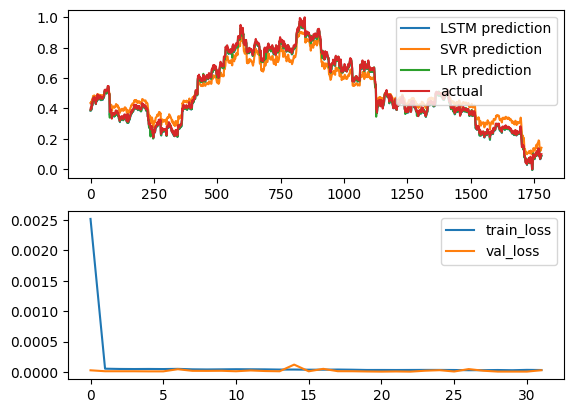

In [15]:
from numpy import sqrt

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import backend as K

import matplotlib.pyplot as plt

# Read
data = pd.read_csv("/kaggle/input/btcusd-dataset/btc_2h.csv", header=0, index_col=0, skiprows=0)
values = data.values.astype('float64')
# Remove data that would not be known at prediction time ("high", "low", "close")
values = values[:, 0:4:]

# Split data into test, train and validation with validation as most recent data
percent = int(values.shape[0]*0.01)
train = values[:percent*66, :]
val = values[percent*23:percent*90, :]
test = values[percent*90:percent*100, :]

# Split and scale data into train, val test sets
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
val = scaler.fit_transform(val)
test = scaler.fit_transform(test)

train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input for LSTM into [samples, timesteps, features]
train_X_lstm = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X_lstm = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X_lstm = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# SVR
svr = SVR()
svr.fit(train_X, train_y)

# LR
lr = LinearRegression()
lr.fit(train_X, train_y)

# LSTM
lstm_model = Sequential()
units = int(train_X_lstm.shape[0]/10)
lstm_model.add(LSTM(units, input_shape=(
    train_X_lstm.shape[1], train_X_lstm.shape[2])))
lstm_model.add(Dropout(0.1))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
history = lstm_model.fit(train_X_lstm, train_y, epochs=32, batch_size=24,
                         validation_data=(val_X_lstm, val_y))


# Make predictions
lstm_predict = lstm_model.predict(test_X_lstm, batch_size=24)
lr_predict = lr.predict(test_X)
svr_predict = svr.predict(test_X)


# Generate & print metrics
def generate_metrics(y_true, y_pred):
    return (
        f"MAE: {round(mean_absolute_error(y_true, y_pred), 9)}",
        f"MSE: {round(mean_squared_error(y_true, y_pred), 9)}",
        f"RMSE: {round(sqrt(mean_squared_error(y_true, y_pred)), 9)}",
        f"R2: {round(r2_score(y_true, y_pred), 9)}",
        f"EV: {round(explained_variance_score(y_true, y_pred), 9)}"
    )


lstm_metrics = generate_metrics(test_y, lstm_predict)
lr_metrics = generate_metrics(test_y, lr_predict)
svr_metrics = generate_metrics(test_y, svr_predict)

print("\nMetrics:")
print(f"LSTM:\t{lstm_metrics}")
print(f"LR:\t{lr_metrics}")
print(f"SVR:\t{svr_metrics}")

# Plot actual and predictions, loss history
fig, ax = plt.subplots(2)
ax[0].plot(lstm_predict[:, -1], label='LSTM prediction')
ax[0].plot(svr_predict, label='SVR prediction')
ax[0].plot(lr_predict, label='LR prediction')
ax[0].plot(test_y, label='actual')
ax[0].legend(loc='upper right')
ax[1].plot(history.history['loss'], label='train_loss')
ax[1].plot(history.history['val_loss'], label='val_loss')
ax[1].legend(loc='upper right')
plt.show()